In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
import random

#save and load dictionaries/lists
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
li_binmn = config.li_binmn
penalty = config.penalty
dico_window = config.dico_window
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
min_date_drivers = config.min_date_drivers
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_dr = os.path.join(path_extracted_data,'Drivers')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_dr):
    os.makedirs(path_extracted_data_visual_dr)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [4]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,pen9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,pen11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,pen5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [5]:
#info on selection process: 
#when possible (i.e. enough MEXP in each pens), 25% (resp.25%) of focal bird were selected randomly among the MEXP (resp. LEXP) 
#remaining 50% of focal animals were selected as a representative sample of the population (called here EPI, as part of a larger study
#with epigenetics aanalysis)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(12, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Treatment,R-Pen,CLASS,HenID
0,OFH,1.0,EPI,20
1,OFH,1.0,LEXP,9
2,OFH,1.0,MEXP,10
3,OFH,3.0,EPI,20
4,OFH,3.0,LEXP,8
5,OFH,3.0,MEXP,9
6,TRAN,2.0,EPI,21
7,TRAN,2.0,LEXP,10
8,TRAN,2.0,MEXP,6
9,TRAN,4.0,EPI,19


In [6]:
#info on selection process: repartition of Rearing pen in laying pen across class
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS',
                                                                                                 'PenID'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(47, 5)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Treatment,R-Pen,CLASS,PenID,HenID
0,OFH,1.0,EPI,pen11,5
1,OFH,1.0,EPI,pen3,5
2,OFH,1.0,EPI,pen5,5
3,OFH,1.0,EPI,pen9,5
4,OFH,1.0,LEXP,pen11,2
5,OFH,1.0,LEXP,pen3,2
6,OFH,1.0,LEXP,pen5,3
7,OFH,1.0,LEXP,pen9,2
8,OFH,1.0,MEXP,pen11,2
9,OFH,1.0,MEXP,pen3,3


In [7]:
#info on selection process: repartition of class in laying pen
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','PenID','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(24, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Treatment,PenID,CLASS,HenID
0,OFH,pen11,EPI,10
1,OFH,pen11,LEXP,3
2,OFH,pen11,MEXP,4
3,OFH,pen3,EPI,10
4,OFH,pen3,LEXP,5
5,OFH,pen3,MEXP,5
6,OFH,pen5,EPI,10
7,OFH,pen5,LEXP,4
8,OFH,pen5,MEXP,5
9,OFH,pen9,EPI,10


In [8]:
#info on selection process: uniform representation of rearing pen identity (RPenID) in each LPenID
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['PenID','R-Pen'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(16, 3)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,R-Pen,HenID
0,pen10,2.0,9
1,pen10,4.0,10
2,pen11,1.0,9
3,pen11,3.0,8
4,pen12,2.0,10
5,pen12,4.0,10
6,pen3,1.0,10
7,pen3,3.0,10
8,pen4,2.0,9
9,pen4,4.0,9


In [9]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
df_daily = df_daily[df_daily['level']>min_date_drivers] 
df_daily = df_daily[['HenID','PenID','level','Treatment', 'CLASS', 'DOA','WOA', 'perc_duration_2_Zone',
                     'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone','Total_number_transition',
                    'vertical_travel_distance_perh']]
#display(df_daily[df_daily.isna().any(axis=1)])
if df_daily[df_daily.isna().any(axis=1)].shape[0]>0:
    print('ERROR')
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(36291, 13)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_transition,vertical_travel_distance_perh
44,hen_131,pen10,2020-11-15,TRAN,EPI,165,24,31.0,53.0,4.0,12.0,38.0,2.533333
45,hen_131,pen10,2020-11-16,TRAN,EPI,166,24,27.0,55.0,6.0,13.0,25.0,1.733333
46,hen_131,pen10,2020-11-17,TRAN,EPI,167,24,33.0,54.0,4.0,9.0,44.0,2.933333


In [10]:
min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(24, 60)

# Choose subset of hens

In [11]:
df_doa = df_daily[['level','DOA','WOA']].drop_duplicates()
df_doa.head(10)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,DOA,WOA
44,2020-11-15,165,24
45,2020-11-16,166,24
46,2020-11-17,167,24
47,2020-11-18,168,24
48,2020-11-19,169,25
49,2020-11-20,170,25
50,2020-11-21,171,25
51,2020-11-22,172,25
52,2020-11-24,174,25
53,2020-11-25,175,25


In [12]:
#### take birds that have at least 2 weights recorded (to be able to estimate in between)
li_weight = ['29-09 weight','weight 23-11-2020','weight 04-01-2021','weight 01-02-21','weight 12-04-21','weight 26-07-21']
df_FB['nbr_weight'] = df_FB.apply(lambda x: sum([math.isnan(i)==False for i in x[li_weight].tolist()]), axis=1)
print(df_FB.shape)
display(df_FB.head(5))
li_selected_hens = df_FB[df_FB['nbr_weight']>=3]['HenID'].tolist() #to think of: birds that needs to adapt to new backapck
len(li_selected_hens)

(232, 15)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment,nbr_weight
0,hen_1,pen9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH,4
1,hen_10,pen11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH,6
2,hen_100,pen5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH,2
3,hen_101,pen5,MEXP,3.0,2020-06-10,0.0,1082.0,66.0,1625.7,1751.1,1723.4,1762.5,1755.3,OFH,6
4,hen_102,pen3,MEXP,3.0,2020-06-10,0.0,1158.0,68.8,1855.1,2013.3,2142.7,2112.5,2042.7,OFH,6


175

In [13]:
#### take birds that have at least have 10 days recorded
df_ = df_daily.groupby(['HenID'])[['Total_number_transition','level']].agg(lambda x: list(x)).reset_index()
df_['nbr_days_involved'] = df_['Total_number_transition'].map(lambda x: len(x))
df_ = df_[df_['HenID'].isin(li_selected_hens)]
print(df_.shape)
df_.sort_values(['nbr_days_involved']).head(20) #for now keep all!!

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(175, 4)


,HenID,Total_number_transition,level,nbr_days_involved
196,hen_86,"[50.0, 41.0, 43.0, 44.0, 58.0, 61.0, 76.0, 64....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
42,hen_142,"[86.0, 71.0, 72.0, 76.0, 74.0, 64.0, 84.0, 78....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
138,hen_27,"[88.0, 85.0, 78.0, 83.0, 76.0, 89.0, 75.0, 84....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
143,hen_34,"[35.0, 60.0, 62.0, 44.0, 55.0, 54.0, 58.0, 65....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
146,hen_40,"[42.0, 54.0, 60.0, 73.0, 55.0, 39.0, 55.0, 42....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
25,hen_123,"[14.0, 24.0, 16.0, 21.0, 15.0, 32.0, 33.0, 39....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
22,hen_12,"[41.0, 58.0, 46.0, 34.0, 53.0, 51.0, 65.0, 51....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",67
0,hen_1,"[30.0, 28.0, 39.0, 44.0, 39.0, 65.0, 54.0, 46....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",68
46,hen_146,"[4.0, 16.0, 4.0, 19.0, 2.0, 2.0, 11.0, 2.0, 8....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",68
140,hen_29,"[45.0, 44.0, 51.0, 63.0, 37.0, 52.0, 72.0, 41....","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...",68


In [14]:
li_sel_hen2 = df_[df_['nbr_days_involved']>=10]['HenID'].tolist()
li_selected_hens = [h for h in li_selected_hens if h in li_sel_hen2]
print(len(li_selected_hens))

175


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#save the list of selected hens 
pickle.dump(li_selected_hens, open(os.path.join(path_extracted_data_visual_dr,'li_selected_hens.pkl'), 'wb'))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
print(df_daily.shape)
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)]
print(df_daily.shape)

(36291, 13)
(34329, 13)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Available data - In words

In [17]:
mi = min(df_daily['DOA'].tolist())
ma = max(df_daily['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 252 days of tracking during the days from the DOA 165 until DOA 417


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
#pen 5 had issues with batteries of markers!
df_info['nbrDaysTracked'].mean()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-3296d942a0e5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
162,hen_86,"[165, 166, 167, 168, 169, 170, 171, 172, 174, ...","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...","[pen3, pen3, pen3, pen3, pen3, pen3, pen3, pen...",67
36,hen_142,"[165, 166, 167, 168, 169, 170, 171, 172, 174, ...","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...","[pen4, pen4, pen4, pen4, pen4, pen4, pen4, pen...",67
113,hen_27,"[165, 166, 167, 168, 169, 170, 171, 172, 174, ...","[2020-11-15 00:00:00, 2020-11-16 00:00:00, 202...","[pen3, pen3, pen3, pen3, pen3, pen3, pen3, pen...",67


196.16571428571427

In [19]:
print('Hens had in average %d days tracked with a minimum of %d days tracked.'%(round(df_info['nbrDaysTracked'].mean(),0),
                                                                                df_info['nbrDaysTracked'].min()))

Hens had in average 196 days tracked with a minimum of 67 days tracked.


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_daily['HenID'].unique()),
                                                                                                   df_daily.shape[0]))

In other words, 175 hens were used in subsequent analysis with a total of 34329 observations.


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Available data - Visually

In [21]:
#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','perc_duration_5_Zone']].copy()
dico_cl = {'EPI':'unknown', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'unknown', 'MEXPLOST':'unknown','NewAfterEpi':'unknown',
          'NewAfterEpiLOST':'unknown'}
df_plt['CLASS'] = df_plt['CLASS'].map(lambda x: dico_cl[x])

##### find missing days
Daterange = pd.date_range(start = min_date_drivers, end = df_daily['level'].max(), freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]

##### add one row per missing dates for a random hen with perc_duration_5_Zone beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'perc_duration_5_Zone':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()

##### say if bird was tracked on taht day or not (i.e. we have his duration in zone 5)
df_plt['Tracked'] = df_plt['perc_duration_5_Zone'].map(lambda x: int(not math.isnan(x)))
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='Tracked').reset_index()
df_plt = df_plt.fillna(0)
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(34329, 6)
(34343, 6)


,HenID,PenID,Treatment,CLASS,level,perc_duration_5_Zone,Tracked
34329,hen_131,pen10,TRAN,unknown,2020-11-14,NaN,0
0,hen_131,pen10,TRAN,unknown,2020-11-15,12.0,1
28302,hen_51,pen8,TRAN,unknown,2020-11-15,63.0,1


(175, 258)


level,HenID,PenID,Treatment,CLASS,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,...,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25
104,hen_211,pen10,TRAN,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
133,hen_57,pen10,TRAN,unknown,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
135,hen_59,pen10,TRAN,unknown,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


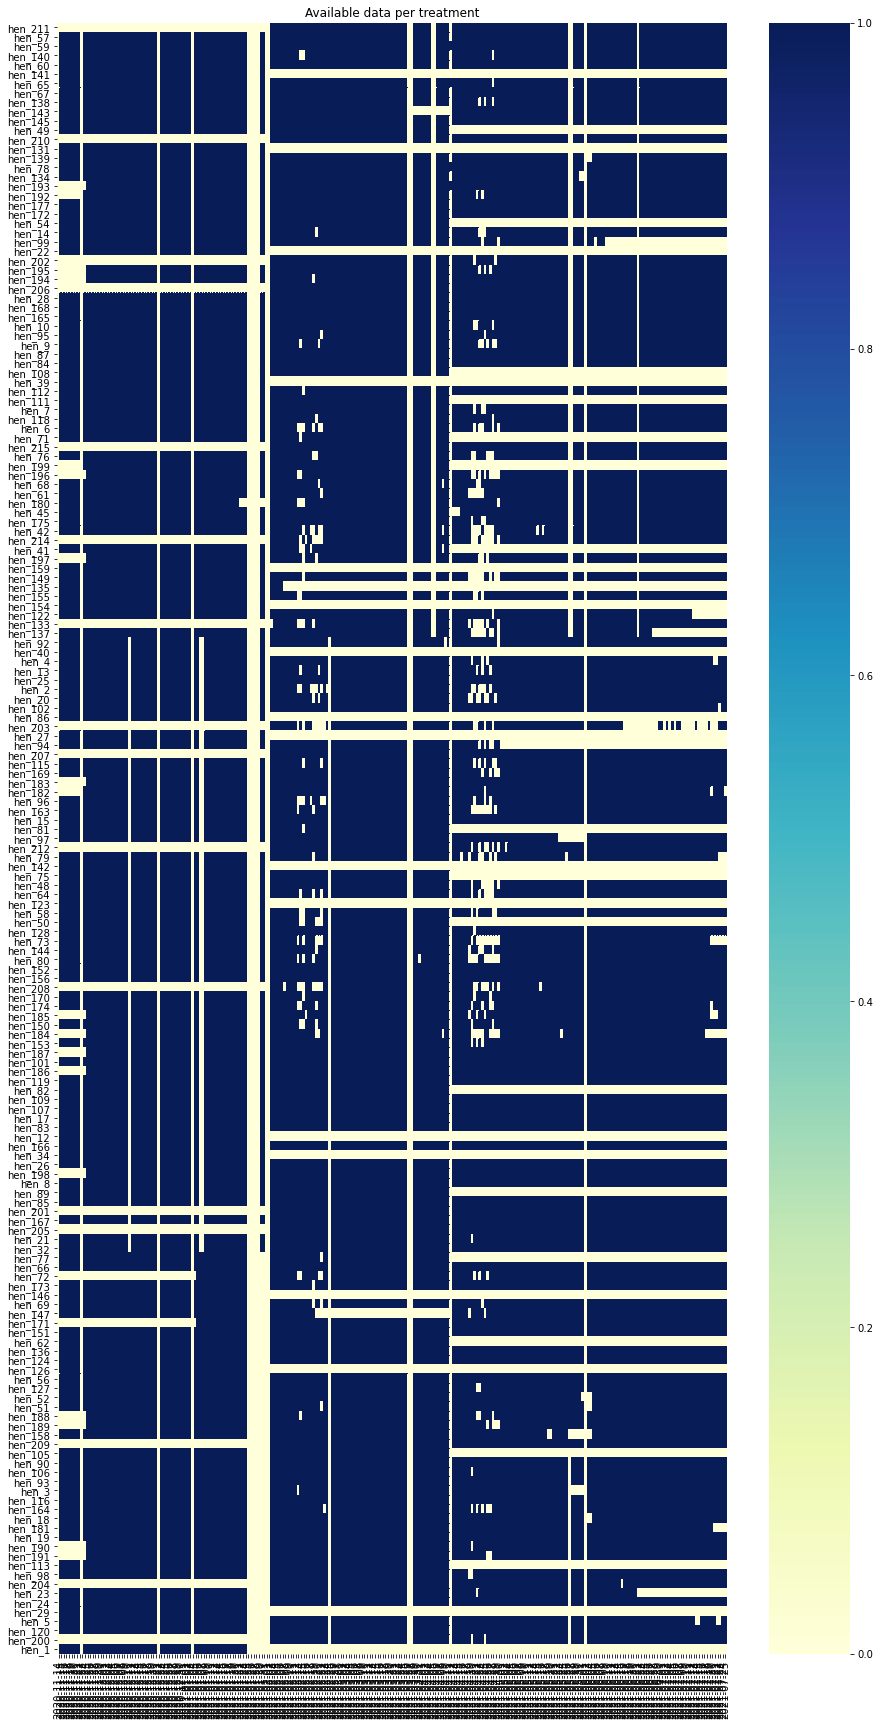

In [22]:
#per hens
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_visual_dr,'DataPerHens.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


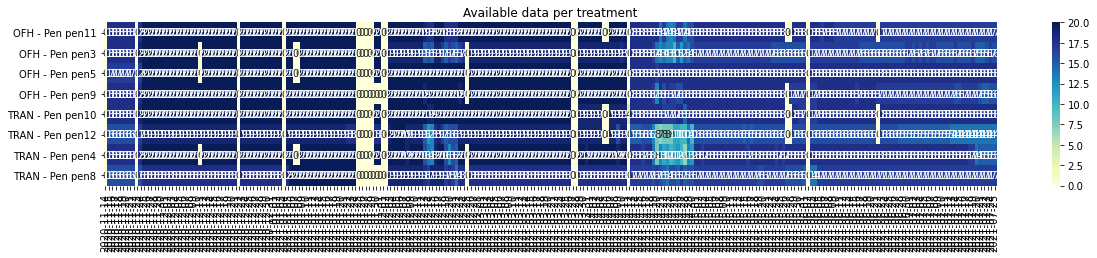

In [23]:
#per treatment
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(20,3))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_visual_dr,'DataPerTreatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


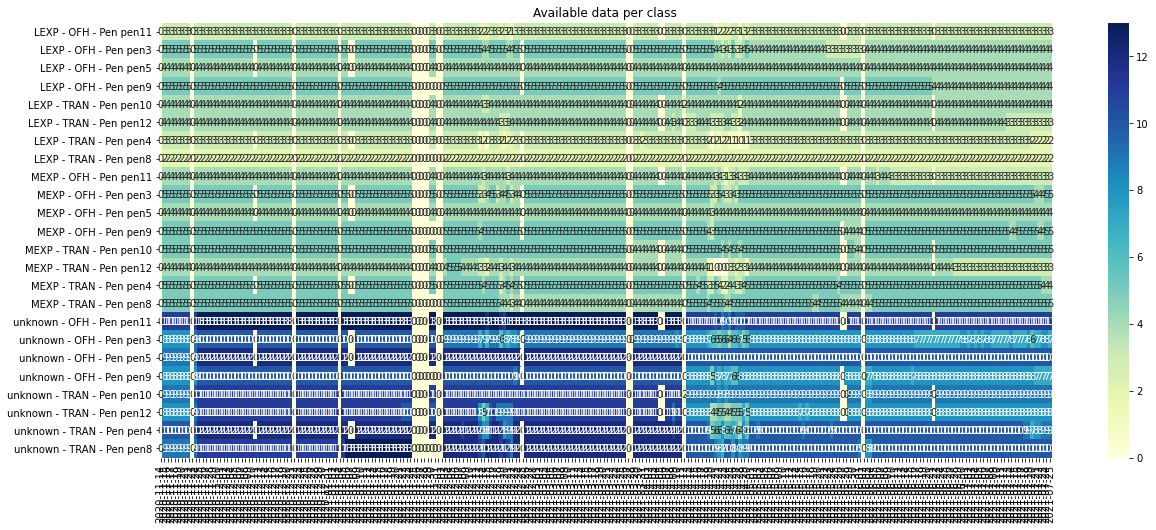

In [24]:
#per class
df_plt_summarized = df_plt.groupby(['CLASS','Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['CLASS']+' - '+x['Treatment']+' - Pen '+str(x['PenID']), 
                                                    axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per class')
plt.savefig(os.path.join(path_extracted_data_visual_dr,'DataPerClass.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()